# Toy topology and signals dataset

In [79]:
import numpy as np 
import cvxpy as cp 
import networkx as nx

from itertools import combinations 
from tqdm import tqdm 
from sklearn.linear_model import OrthogonalMatchingPursuit
from matplotlib import pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Fourier basis + Canonical basis

def FB(
    D:int,
): 

    k = np.arange(D).reshape((D, 1))
    n = np.arange(D).reshape((1, D))

    return np.asmatrix((1/np.sqrt(D)*np.exp(-2j * np.pi * k * n / D)))

In [3]:
B = np.eye(5)

In [4]:
def GrassmanDistance(
        U_A,
        U_B
):
    assert U_A.shape == U_B.shape
    
    _, S, _ = np.linalg.svd(U_A.T @ U_B)
    S = np.clip(S, -1.0, 1.0)
    
    return np.linalg.norm(np.arccos(S))

In [5]:
def subSpaceAssignment(N:int,
                       D:int,
                       K:int):
    
    combo = list(combinations(range(D), K))
    patterns = np.random.choice(len(combo), N, replace=True)
    return {n: np.array(combo[patterns[n]], dtype = 'int32') for n in range(N)}

In [2]:
def premultiplier(Xu, Xv):
    uu = np.linalg.inv(Xu @ Xu.T)
    uv = Xu @ Xv.T
    vv = np.linalg.inv(Xv @ Xv.T)
    vu = Xv @ Xu.T

    return (uu, uv, vv, vu)

def chi_u(uu, uv, vv, vu):

    return (uu @ uv + np.eye(uu.shape[0])) @ vv @ (vu @ uu @ uv @ vv - np.eye(uu.shape[0])) @ vu @ uu - uu

def chi_v(uu, uv, vv, vu):

    return (uu @ uv + np.eye(uu.shape[0])) @ vv @ (vu @ uu @ uv @ vv - np.eye(uu.shape[0]))

________________

In [7]:
V = 4
edges = [
    (0,1),
    (1,2),
    (1,3),
    (0,2)
]

nodes = [i for i in range(V)]
E = len(edges)

In [8]:
d = 20
k = 5
N = 100000

In [9]:
D = FB(d)

In [10]:
subspaces = {0:np.array([0,1,2,3]),
             1:np.array([3,4,5,6]),
             2:np.array([1,2,3,4]),
             3:np.array([6,7,8,9])}

In [11]:
B = np.eye(d)

In [12]:
list(combinations(range(V), 2))

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [13]:
pair_wise_subspaces_distance = {
    edge: GrassmanDistance(B[:,subspaces[edge[0]]], B[:,subspaces[edge[1]]])
    for edge in list(combinations(range(V), 2))
}

In [14]:
edges

[(0, 1), (1, 2), (1, 3), (0, 2)]

In [15]:
sorted(pair_wise_subspaces_distance.items(), key = lambda x: x[1])

[((0, 2), 1.5707963267948966),
 ((1, 2), 2.221441469079183),
 ((0, 1), 2.7206990463513265),
 ((1, 3), 2.7206990463513265),
 ((0, 3), 3.141592653589793),
 ((2, 3), 3.141592653589793)]

In [16]:
signals = {node: B[:,subspaces[node]] @ np.random.randn(4, N) + np.random.randn(d,N)*0.01
           for node in nodes}

In [17]:
signals[0].shape

(20, 100000)

In [18]:
T = 0

H = {
    edge : {
        edge[0] : None,
        edge[1] : None
    }
for edge in combinations(nodes, 2)
}

In [19]:
for e in tqdm(combinations(nodes,2)):
    u = e[0]
    v = e[1]

    X_u = signals[u]
    X_v = signals[v]
    uu, uv, vv, vu = premultiplier(X_u, X_v)

    H[e][u] = chi_u(uu, uv, vv, vu)
    H[e][v] = chi_u(uu, uv, vv, vu)
    
    T += np.trace(H[e][u]) + np.trace(H[e][v])

0it [00:00, ?it/s]

6it [00:00, 41.57it/s]


In [20]:
mu = 1e3

In [21]:
H = {
    edge : {
        edge[0] : mu/T * (H[edge][edge[0]]),
        edge[1] : mu/T * (H[edge][edge[1]])
    }
for edge in combinations(nodes, 2)
}

In [22]:
all_edges = list(combinations(range(V), 2))

energies = {
    e : 0
    for e in all_edges
    }

for e in (all_edges):
    u = e[0]
    v = e[1]
    
    '''
    X_ = np.zeros_like(X)
    X_[u*d:(u+1)*d,:] = X[u*d:(u+1)*d,:]
    X_[v*d:(v+1)*d,:] = X[v*d:(v+1)*d,:]
    energies[e] = np.linalg.norm(BB @ X_)
    '''

    energies[e] = np.linalg.norm(H[e][e[0]] @ signals[e[0]] - H[e][e[1]] @ signals[e[1]])

In [23]:
retrieved = sorted(energies.items(), key=lambda x:x[1])[:E]

In [24]:
print(f'Accuracy in retrieving underlying graph {len(set(list(map(lambda x: x[0], retrieved))).intersection(set(edges))) / E}')

Accuracy in retrieving underlying graph 1.0


In [25]:
retrieved

[((0, 2), 31.740971737865042),
 ((1, 2), 44.71127590129284),
 ((0, 1), 54.751635800766984),
 ((1, 3), 54.960423543043774)]

_______________

In [73]:
class GrassmanGraph:
    def __init__(
            self, 
            N, 
            D, 
            K, 
            E = None,
            basis = None, 
            seed = 42,
            snaps = 1000,
            threshold = None,
            basis_mode = 'Canonic'
        ):
        
        assert N >= D
        
        self.N = N
        self.D = D
        self.K = K
        self.E = E
        
        self.threshold = threshold
        self.snaps = snaps

        self.basis = basis
        self.basis_mode = basis_mode
        
        self.seed = seed

        self.setup()

    def setup(self):

        self.subSpaceAssignment()
        self.pairwise_distances()
        self.edges_generation()
        self.signals_generation()

    def subSpaceAssignment(self):
        
        np.random.seed(self.seed)
        return {n: np.random.choice(self.D, self.K, replace = False) for n in range(self.N)}
    
    def GrassmanDistance(
            self,
            U_A,
            U_B
        ):
        
        assert U_A.shape == U_B.shape
        
        _, S, _ = np.linalg.svd(U_A.T @ U_B)
        S = np.clip(S, -1.0, 1.0)
        
        return np.linalg.norm(np.arccos(S))
    
    def pairwise_distances(self):
        self.SSA = self.subSpaceAssignment()
        if self.basis_mode == 'Canonic':
            self.basis = np.eye(self.D)
        else:
            self.basis = self.basis

        self.pair_wise_subspaces_distance = {
            edge: self.GrassmanDistance(self.basis[:,self.SSA[edge[0]]], self.basis[:,self.SSA[edge[1]]])
            for edge in list(combinations(range(self.N), 2))
            }
        
    def edges_generation(self):
        if self.threshold is None and self.E is None:
            Ds = np.array(sorted(self.pair_wise_subspaces_distance.values()))
            self.edges = [
                pair[0] 
                for pair in list(
                    sorted(
                        self.pair_wise_subspaces_distance.items(), key = lambda x: x[1] 
                        )
                    )
                if pair[1] < np.percentile(Ds, 50)
                ]
            
        elif self.E is not None:
            self.edges = [
                pair[0] for pair in list(
                    sorted(
                        self.pair_wise_subspaces_distance.items(), key = lambda x: x[1] 
                        )
                    )
                ][:self.E]
        
        else:
            self.edges = [
                pair[0] for pair in list(
                    sorted(
                        self.pair_wise_subspaces_distance.items(), key = lambda x: x[1] 
                        )
                    )
                if pair[1] <= self.threshold
                ]
            
    def signals_generation(self):

        np.random.seed(self.seed)
        self.signals = {
                node: self.basis[:,self.SSA[node]] @ np.random.randn(self.K, self.snaps) + np.random.randn(self.N,self.snaps)*0.01
                for node in range(self.N)
                }

In [126]:
class SheafInference:
    def __init__(
            self, 
            GG, 
            mu,
            verbose = False):
        
        self.GG = GG
        self.mu = mu

        self.verbose = verbose
        
        self.KKT_solver()
        self.graph_solver()
        
    def premultiplier(self, Xu, Xv):
        uu = np.linalg.inv(Xu @ Xu.T)
        uv = Xu @ Xv.T
        vv = np.linalg.inv(Xv @ Xv.T)
        vu = Xv @ Xu.T

        return (uu, uv, vv, vu)

    def chi_u(self, uu, uv, vv, vu):

        return (uu @ uv + np.eye(uu.shape[0])) @ vv @ (vu @ uu @ uv @ vv - np.eye(uu.shape[0])) @ vu @ uu - uu

    def chi_v(self, uu, uv, vv, vu):

        return (uu @ uv + np.eye(uu.shape[0])) @ vv @ (vu @ uu @ uv @ vv - np.eye(uu.shape[0]))
    
    def KKT_solver(self):
        T = 0

        H = {
            edge : {
                edge[0] : None,
                edge[1] : None
            }
        for edge in combinations(range(self.GG.N), 2)
        }

        for e in combinations(range(self.GG.N),2):
            u = e[0]
            v = e[1]

            X_u = self.GG.signals[u]
            X_v = self.GG.signals[v]
            uu, uv, vv, vu = self.premultiplier(X_u, X_v)

            H[e][u] = self.chi_u(uu, uv, vv, vu)
            H[e][v] = self.chi_u(uu, uv, vv, vu)
            
            T += np.trace(H[e][u]) + np.trace(H[e][v])

        self.H = {
            edge : {
                edge[0] : self.mu/T * (H[edge][edge[0]]),
                edge[1] : self.mu/T * (H[edge][edge[1]])
            }
        for edge in combinations(range(self.GG.N), 2)
        }
    
    def graph_solver(self):
        all_edges = list(combinations(range(self.GG.N), 2))

        energies = {
            e : 0
            for e in all_edges
            }

        for e in all_edges:

            energies[e] = np.linalg.norm(self.H[e][e[0]] @ self.GG.signals[e[0]] - self.H[e][e[1]] @ self.GG.signals[e[1]])

        self.retrieved = sorted(energies.items(), key=lambda x:x[1])

        if self.verbose:
            print(f'Accuracy in retrieving underlying graph {len(set(list(map(lambda x: x[0], self.retrieved[:len(self.GG.edges)]))).intersection(set(self.GG.edges))) / len(self.GG.edges)}')

        self.acc = len(set(list(map(lambda x: x[0], self.retrieved[:len(self.GG.edges)]))).intersection(set(self.GG.edges))) / len(self.GG.edges)

In [123]:
G = GrassmanGraph(20, 20, 5, E = 30)

In [124]:
S = SheafInference(G, 1e2, verbose=True)

Accuracy in retrieving underlying graph 0.6333333333333333


### First experiment: range number of edges from 1 to 190 and look at accuracy

In [127]:
G = GrassmanGraph(20, 20, 3)
S = SheafInference(G, 1e2)

In [60]:
accs = np.zeros(190)
for i in tqdm(range(1,191)):
    G = GrassmanGraph(20, 20, 3, E = i)
    S = SheafInference(G, 1e2)
    accs[i-1] = S.acc

100%|██████████| 190/190 [01:21<00:00,  2.34it/s]


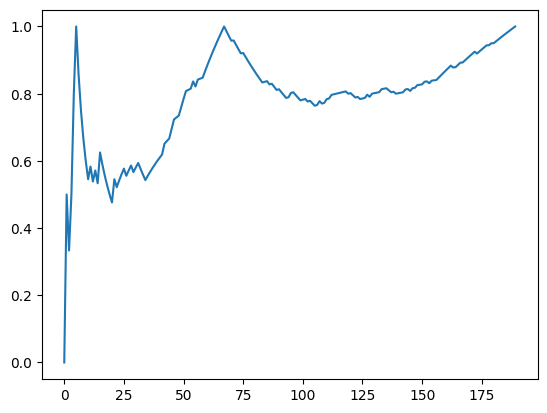

In [61]:
plt.plot(accs)

### Let's have a look to the reconstruction error

In [125]:
def block_ortho_match_pursuit(Y, D, K):

    S = []

    X = np.zeros((D.shape[1], Y.shape[1]))
    iters = 0
    R = Y

    while iters < K:

        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        S.append(np.argmax(np.linalg.norm(D.T @ R, axis = 1)))

        # Expand the dictionary for the representation
        dic = D[:,S]

        # Solve subproblems and update x
        X[S] = np.linalg.pinv(dic) @ Y
        
        # Update the residuals
        R = Y - D @ X
        iters += 1

    return X

In [133]:
Y = np.vstack([G.signals[v] for v in range(20)])

In [134]:
Y.shape

(400, 1000)

In [137]:
reconstruction_error = np.zeros(190)
Y = np.vstack([G.signals[v] for v in range(20)])

for i in tqdm(range(1,191)):

    edges = [tup[0] for tup in S.retrieved][i:]
    B = np.zeros((20*len(edges), 400))
    for j, edge in enumerate(edges):
        
        B[j*20:(j+1)*20, edge[0]*20:(edge[0]+1)*20] = S.H[edge][edge[0]]
        B[j*20:(j+1)*20, edge[1]*20:(edge[1]+1)*20] = - S.H[edge][edge[1]]

    Lf = B.T @ B

    _, U = np.linalg.eig(Lf)
    X = block_ortho_match_pursuit(Y, U, 60)

    reconstruction_error[i - 1] = np.linalg.norm(Y - U @ X)


100%|██████████| 190/190 [09:54<00:00,  3.13s/it]


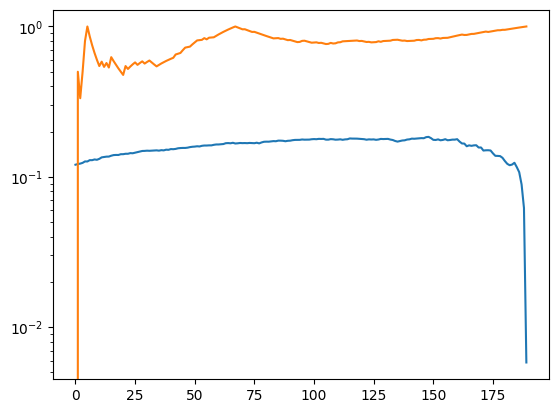

In [141]:
plt.plot(reconstruction_error / 1000)
plt.plot(accs)
plt.yscale('log')